<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/cnn_small_cicids2017_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrusion Detection by using small CICIDS 2017 DataSet with 4000 examples each type

In [1]:
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d

In [3]:
# chganges label from string to integer/index
def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

In [4]:
def get_dataframe_ofType(df, traffic_type):
    """
    Analyze traffic distribution of pandas data frame containing IDS2017 CSV
    file with labelled traffic

    Parameter
    ---------
    df: DataFrame
        Pandas DataFrame corresponding to the content of a CSV file
    traffic_type: string
        name corresponding to traffic type

    Return
    ------
    req_df: DataFrame
        Pandas DataFrame containing only the requested traffic type
    """
    req_df = df.loc[df['Label'] == traffic_type]
    # don't keep original indexes
    #req_df = req_df.reset_index()
    return req_df

In [5]:
def get_typelist(df):
    """
    Extract traffic type from a pandas data frame containing IDS2017 CSV
    file with labelled traffic

    Parameter
    ---------
    df: DataFrame
        Pandas DataFrame corresponding to the content of a CSV file

    Return
    ------
    traffic_type_list: list
        List of traffic types contained in the DataFrame
    """
    traffic_type_list = df['Label'].value_counts().index.tolist()
    return traffic_type_list

In [6]:
#We balance data as follows:
#1) oversample small classes so that their population/count is equal to mean_number_of_samples_per_class
#2) undersample large classes so that their count is equal to mean_number_of_samples_per_class
def balance_data(X,y,seed, mean_samples):
    np.random.seed(seed)
    unique,counts = np.unique(y,return_counts=True)
    mean_samples_per_class = mean_samples # int(round(np.mean(counts)))
    N,D = X.shape #(number of examples, number of features)
    new_X = np.empty((0,D)) 
    new_y = np.empty((0),dtype=int)
    for i,c in enumerate(unique):
        temp_x = X[y==c]
        indices = np.random.choice(temp_x.shape[0],mean_samples_per_class) # gets `mean_samples_per_class` indices of class `c`
        new_X = np.concatenate((new_X,temp_x[indices]),axis=0) # now we put new data into new_X 
        temp_y = np.ones(mean_samples_per_class,dtype=int)*c
        new_y = np.concatenate((new_y,temp_y),axis=0)
        
    # in order to break class order in data we need shuffling
    indices = np.arange(new_y.shape[0])
    np.random.shuffle(indices)
    new_X =  new_X[indices,:]
    new_y = new_y[indices]
    return (new_X,new_y)

## Step 1. Read cleaned CICIDS2017 dataset

Connect to Google Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# All columns
col_names = np.array(['Source Port', 'Destination Port',
                      'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min', 'Label'])

According to "**Selection and Performance Analysis of CICIDS2017 Features Importance**", the important features are: *Destination Port, Fwd IAT Min, Init_Win_bytes_Forward, Init_Win_bytes_backward* and *FlowIATMin*

In [12]:
col_important = np.array(['Source Port', 'Destination Port', 'Fwd IAT Min', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Flow IAT Min',
                      'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Protocol', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min', 'Label'])

In [13]:
# load train data
df_train = pd.read_csv('/content/drive/My Drive/CICIDS2017/train_set.csv',names=col_names, skiprows=1)  
#df_train = pd.read_csv('/content/drive/My Drive/CICIDS2017/train_set.csv',names=col_important, skiprows=1) 
df_train.head()

,,,,,,,,,,,,,,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
5141,172.16.0.1-192.168.10.50-50294-80-6,172.16.0.1,50294.0,192.168.10.50,80.0,6.0,5/7/2017 10:33,63101744.0,7.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.110932,10500000.0,1.190000e+07,32100000.0,998158.0,63100000.0,1.050000e+07,1.190000e+07,32100000.0,998158.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.110932,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,29200.0,-1.0,0.0,40.0,7006133.0,0.0,7006133.0,7006133.0,18700000.0,12200000.0,32100000.0,8015895.0,DoS Slowhttptest
40963,172.16.0.1-192.168.10.50-37796-1199-6,172.16.0.1,37796.0,192.168.10.50,1199.0,6.0,7/7/2017 2:52,62.0,1.0,1.0,2.0,6.0,2.0,2.0,2.000000,0.000000,6.0,6.0,6.0,0.0,1.290323e+05,32258.064520,62.0,0.000000e+00,62.0,62.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,24.0,20.0,16129.032260,16129.032260,2.0,6.0,3.333333,2.309401,5.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5.000000,2.000000,6.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,6.0,1024.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PortScan
27718,172.217.6.200-192.168.10.12-443-42634-6,172.217.6.200,443.0,192.168.10.12,42634.0,6.0,03/07/2017 09:49:12,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,666666.666667,3.0,0.000000e+00,3.0,3.0,3.0,3.000000e+00,0.000000e+00,3.0,3.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,666666.666667,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,357.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
106492,192.168.10.8-23.208.79.206-52235-443-6,192.168.10.8,52235.0,23.208.79.206,443.0,6.0,4/7/2017 11:46,5007496.0,7.0,4.0,1679.0,152.0,1080.0,0.0,239.857143,415.237052,152.0,0.0,38.0,76.0,3.656518e+02,2.196707,500749.6,1.543257e+06,4892570.0,3.0,5007496.0,8.345827e+05,2.018795e+06,4955369.0,3.0,87090.0,29030.0,31709.63089,63179.0,515.0,0.0,0.0,0.0,0.0,152.0,92.0,1.397904,0.798802,0.0,1080.0,152.583333,327.660428,107361.356100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,166.454545,239.857143,38.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1679.0,4.0,152.0,8192.0,946.0,4.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
63559,192.168.10.14-52.84.30.203-59835-80-6,52.84.30.203,80.0,192.168.10.14,59835.0,6.0,6/7/2017 10:04,4.0,1.0,1.0,6.0,6.0,6.0,6.0,6.000000,0.000000,6.0,6.0,6.0,0.0,3.000000e+06,500000.000000,4.0,0.000000e+00,4.0,4.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,250000.000000,250000.000000,6.0,6.0,6.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.000000,6.000000,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,115.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [14]:
df_test = pd.read_csv('/content/drive/My Drive/CICIDS2017/test_set.csv',names=col_names, skiprows=1)  
#df_test = pd.read_csv('/content/drive/My Drive/CICIDS2017/test_set.csv',names=col_important, skiprows=1) 
print('Test set size: ', df_test.shape)

df_val = pd.read_csv('/content/drive/My Drive/CICIDS2017/crossval_set.csv',names=col_names, skiprows=1)  
#df_val = pd.read_csv('/content/drive/My Drive/CICIDS2017/crossval_set.csv',names=col_important, skiprows=1) 
print('Validation set size: ', df_val.shape)

Test set size:  (278270, 72)
Validation set size:  (278270, 72)


In [15]:
# Here we can see the number of rows and columns for each table.
print(df_train.shape)

(556548, 72)


Count the number of attacks

In [ ]:
df_train['Label'].value_counts()

BENIGN                        278274
DoS Hulk                      115062
PortScan                       79402
DDoS                           64012
DoS GoldenEye                   5146
FTP-Patator                     3967
SSH-Patator                     2948
DoS slowloris                   2898
DoS Slowhttptest                2749
Bot                              978
Web Attack  Brute Force         753
Web Attack  XSS                 326
Infiltration                      18
Web Attack  Sql Injection        10
Heartbleed                         5
Name: Label, dtype: int64

In [ ]:
print('Test set: ')
df_test['Label'].value_counts()

Test set: 


BENIGN                        139135
DoS Hulk                       57531
PortScan                       39701
DDoS                           32006
DoS GoldenEye                   2573
FTP-Patator                     1983
SSH-Patator                     1474
DoS slowloris                   1449
DoS Slowhttptest                1374
Bot                              489
Web Attack  Brute Force         376
Web Attack  XSS                 163
Infiltration                       9
Web Attack  Sql Injection         5
Heartbleed                         2
Name: Label, dtype: int64

In [ ]:
print('Validation set: ')
df_val['Label'].value_counts()

Validation set: 


BENIGN                        139135
DoS Hulk                       57531
PortScan                       39701
DDoS                           32006
DoS GoldenEye                   2573
FTP-Patator                     1983
SSH-Patator                     1474
DoS slowloris                   1449
DoS Slowhttptest                1374
Bot                              489
Web Attack  Brute Force         376
Web Attack  XSS                 163
Infiltration                       9
Web Attack  Sql Injection         5
Heartbleed                         2
Name: Label, dtype: int64

## Step 2. Randomly Selecting 2000 examples from each type

First, selecting 4000 examples for each type in train dataset

In [16]:
df_label = df_train['Label']
data = df_train.drop(columns=['Label'])
X = data.values
y = encode_label(df_label.values)

In [17]:
print(X.shape)
print(y.shape)

(556548, 71)
(556548,)


In [18]:
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [278274    978  64012   5146 115062   2749   2898   3967      5     18
  79402   2948    753     10    326]


In [19]:
SEED = 2
X_train,y_train = balance_data(X,y,seed=SEED, mean_samples=4000)

In [20]:
print(X_train.shape)
print(y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print(unique, counts)

(60000, 71)
(60000,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
 4000]


Next, selecting 1000 examples from validation datesets

In [21]:
df_label = df_test['Label']
data = df_test.drop(columns=['Label'])
X = data.values
y = encode_label(df_label.values)

SEED = 2
X_test,y_test = balance_data(X,y,seed=SEED, mean_samples=1000)

Next, selecting 500 examples from test datesets

In [22]:
df_label = df_val['Label']
data = df_val.drop(columns=['Label'])
X = data.values
y = encode_label(df_label.values)

SEED = 2
X_val,y_val = balance_data(X,y,seed=SEED, mean_samples=500)

## Step 3. Normalization

The continuous feature values are normalized into the same feature space. This is important when using features that have different measurements, and is a general requirement of many machine learning algorithms. Therefore, the values for this dataset are also normalized using the Min-Max scaling technique, bringing them all within a range of [0,1].

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00109412, 0.00130398, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0077991 , 0.0197178 , ..., 0.        , 0.05733978,
        0.05733978]])

In [25]:
X_train.shape

(60000, 71)

In [26]:
X_test = scaler.fit_transform(X_test)

In [27]:
X_test.shape

(15000, 71)

In [28]:
X_val = scaler.fit_transform(X_val)
X_val

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00095839, 0.02132314, ..., 0.        , 0.        ,
        0.        ],
       [0.00100857, 0.00039029, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.01865954, 0.0270547 , ..., 0.        , 0.        ,
        0.        ],
       [0.00302572, 0.00117087, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02337832, 0.05175073, ..., 0.        , 0.        ,
        0.        ]])

## Step 4. One-hot encoding for labels

y_train and y_test have to be one-hot-encoded. That means they must have dimension (number_of_samples, 15), where 15 denotes number of classes.

In [29]:
from tensorflow.keras.utils import to_categorical

In [30]:
y_train_v = to_categorical(y_train, 15)
y_test_v = to_categorical(y_test, 15)
y_val_v = to_categorical(y_val, 15)
print(y_train_v.shape)
print(y_test_v.shape)
print(y_val_v.shape)

(60000, 15)
(15000, 15)
(7500, 15)


## Step 5. Build the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [ ]:
#hyper-params
batch_size = 100 # increasing batch size with more gpu added

input_dim = X_train.shape[1]
num_class = 15                   # 15 intrusion classes, including benign traffic class
num_epochs = 90

print(input_dim)
print(num_class)

71
15


In [ ]:
X_train_r = np.zeros((len(X_train), input_dim, 1))
X_train_r[:, :, 0] = X_train[:, :input_dim]
print(X_train_r.shape)

(60000, 71, 1)


In [ ]:
X_val_r = np.zeros((len(X_val), input_dim, 1))
X_val_r[:, :, 0] = X_val[:, :input_dim]
print(X_val_r.shape)

(7500, 71, 1)


In [ ]:
X_test_r = np.zeros((len(X_test), input_dim, 1))
X_test_r[:, :, 0] = X_test[:, :input_dim]
print(X_test_r.shape)

(15000, 71, 1)


**Model with 2 Con1D layers**

In [ ]:
model2 = Sequential()

# input layer
model2.add(Conv1D(filters=60, kernel_size=11,  input_shape=(71,1)))
#model2.add(BatchNormalization(axis=1))
model2.add(Activation('relu'))
model2.add(Dropout(0.1))

model2.add(Conv1D(filters=60, kernel_size=3))
#model2.add(BatchNormalization(axis=1))
model2.add(Activation('relu'))
model2.add(Dropout(0.1))

model2.add(Conv1D(filters=60, kernel_size=7))
#model2.add(BatchNormalization(axis=1))
model2.add(Activation('relu'))
model2.add(Dropout(0.1))

model2.add(Flatten())
#model2.add(Dropout(0.1))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(num_class))
model2.add(Activation('softmax'))

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 61, 60)            720       
_________________________________________________________________
activation (Activation)      (None, 61, 60)            0         
_________________________________________________________________
dropout (Dropout)            (None, 61, 60)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 59, 60)            10860     
_________________________________________________________________
activation_1 (Activation)    (None, 59, 60)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 59, 60)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 53, 60)            2

In [ ]:
learning_rates = 1e-3
optim = tf.keras.optimizers.Adam(lr=learning_rates, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model2.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 

In [ ]:
model2.fit(X_train_r, y_train_v, epochs=100, batch_size=batch_size, validation_data=(X_val_r, y_val_v), verbose=1)

Epoch 1/100
600/600 [==============================] - 10s 4ms/step - loss: 0.9566 - accuracy: 0.6844 - val_loss: 0.3925 - val_accuracy: 0.8560
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2993 - accuracy: 0.8746 - val_loss: 0.3710 - val_accuracy: 0.8488
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2609 - accuracy: 0.8799 - val_loss: 0.3645 - val_accuracy: 0.8527
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2427 - accuracy: 0.8864 - val_loss: 0.3273 - val_accuracy: 0.8615
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2304 - accuracy: 0.8865 - val_loss: 0.3215 - val_accuracy: 0.8669
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2244 - accuracy: 0.8906 - val_loss: 0.3465 - val_accuracy: 0.8791
Epoch 7/100
600/600 [==============================] - 2s 3ms/step - loss: 0.2147 - accuracy: 0.8942 - val_loss: 0.3312 - val_accuracy: 0.857

## Step 6. **Model with DNN layers**

In [ ]:
model = Sequential()

# input layer
model.add(Dense(128,  activation='relu', input_shape = (71,)))
model.add(Dropout(0.1))

# hidden layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))

# hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Flatten()) 
model.add(Dense(num_class))
model.add(Activation('softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               9216      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [ ]:
learning_rates = 1e-4
optim = tf.keras.optimizers.Adam(lr=learning_rates, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 

## Step 7. Training the DNN model

In [ ]:
# fit network
model.fit(X_train, y_train_v, epochs=100, batch_size=batch_size, validation_data=(X_val, y_val_v), verbose=1)

Epoch 1/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1337 - accuracy: 0.9391 - val_loss: 1.0509 - val_accuracy: 0.8891
Epoch 2/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1341 - accuracy: 0.9387 - val_loss: 1.0689 - val_accuracy: 0.8905
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1357 - accuracy: 0.9385 - val_loss: 1.0054 - val_accuracy: 0.8895
Epoch 4/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1346 - accuracy: 0.9396 - val_loss: 0.9986 - val_accuracy: 0.8893
Epoch 5/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1344 - accuracy: 0.9389 - val_loss: 1.0265 - val_accuracy: 0.8912
Epoch 6/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1344 - accuracy: 0.9390 - val_loss: 0.9785 - val_accuracy: 0.8892
Epoch 7/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1349 - accuracy: 0.9390 - val_loss: 0.9900 - val_accuracy: 0.8903

In [ ]:
# evaluate model
accuracy = model.evaluate(X_test_r, y_test_v, batch_size=batch_size, verbose=1)

NameError: ignored

## Step 8. KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score 

In [ ]:
features_order = ['Source Port', 'Destination Port',
                      'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min']

In [ ]:
features=["Fwd Packet Length Max","Flow IAT Std","Fwd Packet Length Std" ,"Fwd IAT Total",'Flow Packets/s', "Fwd Packet Length Mean",  "Flow Bytes/s",  "Flow IAT Mean", "Bwd Packet Length Mean",  "Flow IAT Max", "Bwd Packet Length Std", ]

### Import module for KNN

First, convert numpy array to dataframe

In [ ]:
df_train = pd.DataFrame(X_train, columns = features_order)
df_train.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.0,0.000000,0.000000,0.000345,0.004161,0.001528,0.000000,8.750368e-09,2.006996e-06,1.670159e-03,0.003210,4.163675e-03,3.294118e-06,0.008277,0.004139,0.000067,0.004167,4.110400e-03,0.008277,0.004170,0.000063,0.004199,4.140332e-03,0.0,0.0,0.0,0.0,0.000833,0.000543,1.501095e-06,3.018877e-06,0.0,0.000242,0.001355,0.000681,4.633205e-07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.142857,0.001451,0.000000,0.001528,0.000833,0.0,0.0,0.0,0.0,0.0,0.0,0.000362,0.000000,0.000543,2.283559e-06,0.125015,0.000015,0.000000,0.636364,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,8.658003e-03,6.428571e-07,0.000000,6.333333e-07,6.554622e-07,0.000000,0.000000,0.000000,0.000000,8.333333e-09,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000290,0.000290,6.493498e-03,1.298701e-02,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.142857,0.000000,0.000000,0.000000,0.000290,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000181,0.000000e+00,0.003967,0.003784,0.000000,0.727273,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.001094,0.001304,0.000000,0.000000,0.000000,0.000000,2.991039e-10,4.203819e-08,8.823529e-02,0.174941,1.750000e-01,5.882353e-07,0.175000,0.175000,0.000000,0.175000,1.750000e-01,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.0,0.0,0.0,0.0,0.000579,0.000290,3.928256e-08,4.762654e-08,0.0,0.000524,0.003424,0.001594,2.537538e-06,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.004191,0.001094,0.000000,0.000579,0.0,0.0,0.0,0.0,0.0,0.0,0.000181,0.000005,0.000181,0.000000e+00,0.003510,0.003601,0.000000,0.727273,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000345,0.004161,0.001528,0.000000,4.528986e-05,1.041666e-02,5.336134e-07,0.000000,5.250000e-07,5.462185e-07,0.000000,0.000000,0.000000,0.000000,8.333333e-09,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000362,0.000181,7.812492e-03,1.562500e-02,0.0,0.000242,0.001054,0.000736,5.405405e-07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.142857,0.001451,0.000000,0.001528,0.000362,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000181,7.611864e-07,0.445572,0.000015,0.000000,0.909091,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.015444,0.025466,0.417300,0.000000,0.590488,0.496983,5.882509e-08,2.495034e-08,1.033613e-01,0.410165,8.183333e-01,4.201681e-08,0.818333,0.272500,0.791899,0.818333,4.166667e-08,0.000022,0.000006,0.000011,0.000015,3.358349e-08,0.0,0.0,0.0,0.0,0.001122,0.001520,1.201514e-08,5.089781e-08,0.0,0.292143,0.630426,0.535618,2.865587e-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.643026,0.015444,0.590488,0.001122,0.0,0.0,0.0,0.0,0.0,0.0,0.000543,0.000128,0.000905,1.470993e-03,0.000015,0.003601,0.000181,0.454545,0.0,0.0,0.0,0.0,0.818333,0.0,0.818333,0.818333


In [ ]:
df_val = pd.DataFrame(X_val, columns = features_order)

Select a subset of features from the dataframe

In [ ]:
df_sub=df_train.loc[:, features]
df_sub.head()

,Fwd Packet Length Max,Flow IAT Std,Fwd Packet Length Std,Fwd IAT Total,Flow Packets/s,Fwd Packet Length Mean,Flow Bytes/s,Flow IAT Mean,Bwd Packet Length Mean,Flow IAT Max,Bwd Packet Length Std
0,2.006996e-06,0.004170,4.163675e-03,4.140332e-03,4.110400e-03,0.003210,0.004167,0.008277,0.004139,0.000063,0.000067
1,8.658003e-03,0.000000,6.333333e-07,0.000000e+00,8.333333e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4.203819e-08,0.000000,1.750000e-01,0.000000e+00,1.750000e-01,0.174941,0.175000,0.000000,0.175000,0.000000,0.000000
3,1.041666e-02,0.000000,5.250000e-07,0.000000e+00,8.333333e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2.495034e-08,0.000006,8.183333e-01,3.358349e-08,4.166667e-08,0.410165,0.818333,0.000022,0.272500,0.000011,0.791899


In [ ]:
df_val_sub=df_val.loc[:, features]
df_val_sub.head()

,Fwd Packet Length Max,Flow IAT Std,Fwd Packet Length Std,Fwd IAT Total,Flow Packets/s,Fwd Packet Length Mean,Flow Bytes/s,Flow IAT Mean,Bwd Packet Length Mean,Flow IAT Max,Bwd Packet Length Std
0,0.007246,0.000000,7.629147e-07,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000014,0.000474,8.344686e-03,8.382044e-09,0.0,0.001867,0.008343,0.991667,0.000358,0.002946,0.002530
2,0.007663,0.000000,7.209963e-07,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000014,0.000484,1.672833e-02,8.382044e-09,0.0,0.001878,0.016715,0.991667,0.000357,0.002999,0.002537
4,0.009804,0.000000,5.617064e-07,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Convert dataframes to numpy array

In [ ]:
X_train = df_sub.to_numpy()
X_val = df_val_sub.to_numpy()

In [ ]:
for i in range(1,X_train.shape[1]+1):
    knn=KNeighborsClassifier(n_neighbors=i)
    model_knn=knn.fit(X_train,y_train)
    yhat=model_knn.predict(X_val)
    print("for " , i,  " as K, accuracy is : ", accuracy_score(y_val, yhat))

for  1  as K, accuracy is :  0.6404
for  2  as K, accuracy is :  0.6353333333333333
for  3  as K, accuracy is :  0.6524
for  4  as K, accuracy is :  0.6562666666666667
for  5  as K, accuracy is :  0.6664
for  6  as K, accuracy is :  0.6624
for  7  as K, accuracy is :  0.6705333333333333
for  8  as K, accuracy is :  0.6737333333333333
for  9  as K, accuracy is :  0.6776
for  10  as K, accuracy is :  0.6786666666666666
for  11  as K, accuracy is :  0.6785333333333333


## Step 9. Random Foresty with DecisionTree 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
clf = RandomForestClassifier(n_estimators=10, random_state=SEED)
clf.fit(X_train,y_train)
    
pred = clf.predict(X_val)
val_acc = metrics.accuracy_score(y_val,pred)*100        
print('val acc:',val_acc)


val acc: 72.72


## Step 10. CONV2D model
Convert each example to a 6x4 color image

In [31]:
X_train_enlarge = np.append(X_train, np.zeros([len(X_train),1]),1)
X_test_enlarge = np.append(X_test, np.zeros([len(X_test),1]),1)

In [32]:
img_row = 6
img_col = 4

X_train_img = np.array([x.reshape(img_row, img_col, 3) for x in X_train_enlarge])
X_test_img = np.array([x.reshape(img_row, img_col, 3) for x in X_test_enlarge])

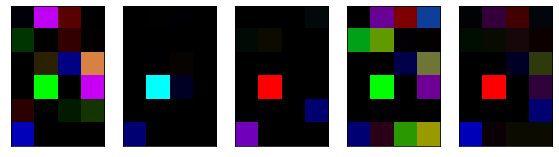

In [33]:
#ploting images for data
%matplotlib inline
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_train_img[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

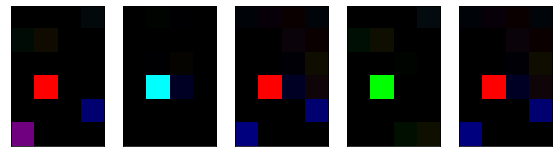

In [34]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_test_img[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

Build a simple CNN model

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [56]:
batch_size = 50 # increasing batch size with more gpu added
 
num_class = 15                   # 15 intrusion classes, including benign traffic class
epochs = 40

In [61]:
model2d = Sequential()
model2d.add(Conv2D(32, kernel_size=(1, 1), activation='relu', input_shape=(6,4,3)))
#model2d.add(MaxPooling2D(pool_size=(1, 1)))
model2d.add(Conv2D(32, kernel_size=(1,1), activation='relu'))
#model2d.add(MaxPooling2D(pool_size=(1, 1)))
model2d.add(Flatten())
model2d.add(Dropout(0.2))
model2d.add(Dense(512))
model2d.add(Dense(num_class, activation='softmax'))
 
model2d.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 6, 4, 32)          128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 6, 4, 32)          1056      
_________________________________________________________________
flatten_7 (Flatten)          (None, 768)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               393728    
_________________________________________________________________
dense_15 (Dense)             (None, 15)                7695      
Total params: 402,607
Trainable params: 402,607
Non-trainable params: 0
________________________________________________

In [62]:
# training
model2d.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])
model2d.fit(X_train_img, y_train_v,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_img, y_test_v))

Epoch 1/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.8867 - accuracy: 0.7097 - val_loss: 0.6294 - val_accuracy: 0.7941
Epoch 2/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.3918 - accuracy: 0.8499 - val_loss: 0.7202 - val_accuracy: 0.7810
Epoch 3/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.3246 - accuracy: 0.8677 - val_loss: 0.9063 - val_accuracy: 0.6654
Epoch 4/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.2886 - accuracy: 0.8757 - val_loss: 0.6517 - val_accuracy: 0.8183
Epoch 5/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.2745 - accuracy: 0.8792 - val_loss: 0.5756 - val_accuracy: 0.8436
Epoch 6/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.2612 - accuracy: 0.8830 - val_loss: 0.8948 - val_accuracy: 0.7433
Epoch 7/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.2485 - accuracy: 0.8851 - val_loss: 0.6870 - val_accuracy:

## Step 11. CONV2D with 9x8 gray image

In [63]:
X_train_enlarge = np.append(X_train, np.zeros([len(X_train),1]),1)
X_test_enlarge = np.append(X_test, np.zeros([len(X_test),1]),1)

In [68]:
img_row = 9
img_col = 8

X_train_gray = np.array([x.reshape(img_row, img_col,1) for x in X_train_enlarge])
train_gray = np.array([x.reshape(img_row, img_col) for x in X_train_enlarge])
X_test_gray = np.array([x.reshape(img_row, img_col,1) for x in X_test_enlarge])
test_gray = np.array([x.reshape(img_row, img_col) for x in X_test_enlarge])

In [65]:
X_train_gray.shape

(60000, 9, 8, 1)

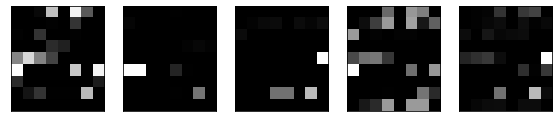

In [69]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(train_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

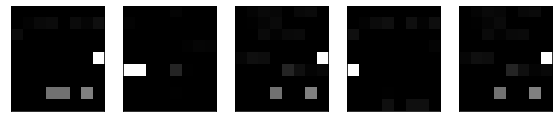

In [70]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [72]:
batch_size = 50 # increasing batch size with more gpu added
 
num_class = 15                   # 15 intrusion classes, including benign traffic class
epochs = 40

In [89]:
model2d_g = Sequential()
model2d_g.add(Conv2D(32, kernel_size=(1, 1), padding = 'same', activation='relu', input_shape=(9,8,1)))
model2d_g.add(Conv2D(64, kernel_size=(1,1), padding = 'same', activation='relu'))
model2d_g.add(Flatten())
model2d_g.add(Dropout(0.1))
model2d_g.add(Dense(512))
model2d_g.add(Dense(num_class, activation='softmax'))
 
model2d_g.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 9, 8, 32)          64        
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 9, 8, 64)          2112      
_________________________________________________________________
flatten_14 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 4608)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dense_29 (Dense)             (None, 15)                7695      
Total params: 2,369,679
Trainable params: 2,369,679
Non-trainable params: 0
___________________________________________

In [91]:
# training
model2d_g.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001), #SGD(lr=0.01),
              metrics=['accuracy'])
model2d_g.fit(X_train_gray, y_train_v,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_gray, y_test_v))

Epoch 1/40
1200/1200 [==============================] - 5s 4ms/step - loss: 0.3443 - accuracy: 0.8623 - val_loss: 0.5925 - val_accuracy: 0.7883
Epoch 2/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.3019 - accuracy: 0.8730 - val_loss: 0.5960 - val_accuracy: 0.8020
Epoch 3/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.2801 - accuracy: 0.8816 - val_loss: 0.5272 - val_accuracy: 0.8633
Epoch 4/40
1200/1200 [==============================] - 4s 4ms/step - loss: 0.2686 - accuracy: 0.8827 - val_loss: 0.5949 - val_accuracy: 0.8285
Epoch 5/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.2573 - accuracy: 0.8861 - val_loss: 0.5476 - val_accuracy: 0.8584
Epoch 6/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.2555 - accuracy: 0.8857 - val_loss: 0.6924 - val_accuracy: 0.7930
Epoch 7/40
1200/1200 [==============================] - 4s 3ms/step - loss: 0.2442 - accuracy: 0.8866 - val_loss: 0.5726 - val_accuracy:

## Step 12. RNN Method

The dataset is not right. It should be time serial data

In [ ]:
from tensorflow.keras.layers import SimpleRNN

In [ ]:
modelrnn = Sequential()
modelrnn.add(SimpleRNN(120, input_shape = (71,1), return_sequences=True))
modelrnn.add(Dropout(0.2))

modelrnn.add(SimpleRNN(120, return_sequences=True))
modelrnn.add(Dropout(0.2))

modelrnn.add(SimpleRNN(120, return_sequences=False))
modelrnn.add(Dropout(0.2))

# multiclass
modelrnn.add(Dense(num_class))
modelrnn.add(Activation('softmax'))

modelrnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 71, 120)           14640     
_________________________________________________________________
dropout_12 (Dropout)         (None, 71, 120)           0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 71, 120)           28920     
_________________________________________________________________
dropout_13 (Dropout)         (None, 71, 120)           0         
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 120)               28920     
_________________________________________________________________
dropout_14 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 15)               

In [ ]:
learning_rates = 1e-4
optim = tf.keras.optimizers.Adam(lr=learning_rates, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
modelrnn.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 

In [ ]:
# fit network
modelrnn.fit(X_train, y_train_v, epochs=100, batch_size=batch_size, validation_data=(X_val, y_val_v), verbose=1)

Epoch 1/100


ValueError: ignored